# Recherche Opérationnelle

Alexandre Tellez - Fabien Cancé - Sean Lamet - Wassim Bennane

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import networkx as nx
import math
import random
from faker import Faker
fake = Faker()
from pulp import *
import random
from collections import deque
from functools import lru_cache
from ipywidgets import IntProgress
from IPython.display import display
from collections import defaultdict
from tqdm import tqdm

# I/ Génération des instances 

## 1.1 Création du Graphe avec les dépandances

### Génération des graphes

Dans un premier temps, nous générons cinq types différents de graphes contenant 30 villes en nous basant sur une droite de régression de la forme *y = ax + b*, en faisant varier le niveau de dispersion (de 0 à 100).  
Une dispersion de 0 signifie que tous les points se situent exactement sur la droite de régression, tandis qu'une dispersion de 100 représente un éparpillement maximal des points autour de cette droite.


In [5]:
random.seed(a=3)
# Fonction qui génère les points et le graphe avec dépendances
def generatePointsDeps(nb_points, dispersion):
    a, b = 1, 0
    x = np.linspace(0, 10, nb_points)
    ecart = np.random.randn(nb_points) * (abs(dispersion))
    y = a * x + b + ecart

    noms = [fake.city() for _ in range(nb_points)]
    points = {noms[i]: (x[i], y[i]) for i in range(nb_points)}

    return noms, points, x, y

# Fonction de création du graphe et des dépendances
def CreationGraphDeps(nb_points, noms, points):
    graphe = {}
    dependances_tuples = []
    deja_dependants = set()  
    deja_pere = set()        

    for i in range(nb_points):
        node_i = noms[i]
        graphe[node_i] = {}
        xi, yi = points[node_i]

        for j in range(nb_points):
            if i != j:
                node_j = noms[j]
                xj, yj = points[node_j]
                distance = round(math.sqrt((xi - xj) ** 2 + (yi - yj) ** 2), 3)
                graphe[node_i][node_j] = distance

    # Création des dépendances
    for node_i in noms:
         if node_i == noms[0]:  # On exclut le dépôt
             continue

         if node_i not in deja_dependants:
             if random.random() < 0.2:
                 possibles = [n for n in noms if n != node_i and n != noms[0] and n not in deja_pere]
                 if possibles:
                     dependance = random.choice(possibles)
                     dependances_tuples.append((dependance, node_i))
                     deja_dependants.add(node_i)
                     deja_pere.add(dependance)

    return graphe, dependances_tuples

# Fonction de pondération des dépendances
def PonderationDeps(graphe1, G):
    for node, voisins in graphe1.items():
        for voisin, poids in voisins.items():
            if voisin != 'dependances':
                G.add_edge(node, voisin, weight=poids)


if __name__ == "__main__":

    instances = []
    dependances_list = []
    x_list = []
    y_list = []

    # Création du graphe et des dépendances
    for nb_points, dispersion in [(30, 0), (30, 10), (30, 50), (30, 70), (30, 100)]:
        noms, points, x, y = generatePointsDeps(nb_points, dispersion)
        instance, dependances = CreationGraphDeps(len(noms), noms, points)
        instances.append(instance)
        dependances_list.append(dependances)
        x_list.append(x)
        y_list.append(y)

## 1.2 Temps d’exécution pour chaque graphe

On va regarder le temps d'exécution pour chaque graphe afin de savoir le temps que prend l'algorithme si on varie le nombre de villes et la dispersion.

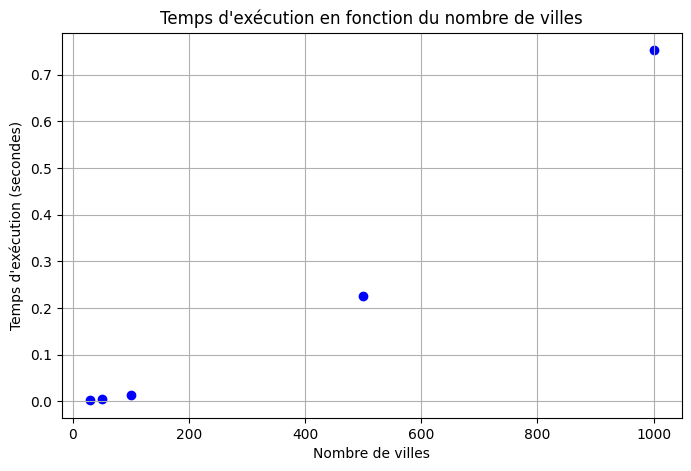

In [6]:
import time 
execution_times = []
nb_villes_list = []

for nb_points, dispersion in [(30, 0), (50, 10), (100, 50), (500, 70), (1000, 100)]:
    start_time = time.time()

    noms, points, x, y = generatePointsDeps(nb_points, dispersion)
    instance, dependances = CreationGraphDeps(len(noms), noms, points)

    end_time = time.time()
    exec_time = end_time - start_time

    execution_times.append(exec_time)
    nb_villes_list.append(nb_points)

plt.figure(figsize=(8, 5))
plt.scatter(nb_villes_list, execution_times, marker='o', linestyle='-', color='blue')
plt.xlabel("Nombre de villes")
plt.ylabel("Temps d'exécution (secondes)")
plt.title("Temps d'exécution en fonction du nombre de villes")
plt.grid(True)
plt.show()

## 1.3 Exemple de graphe avec dépandances

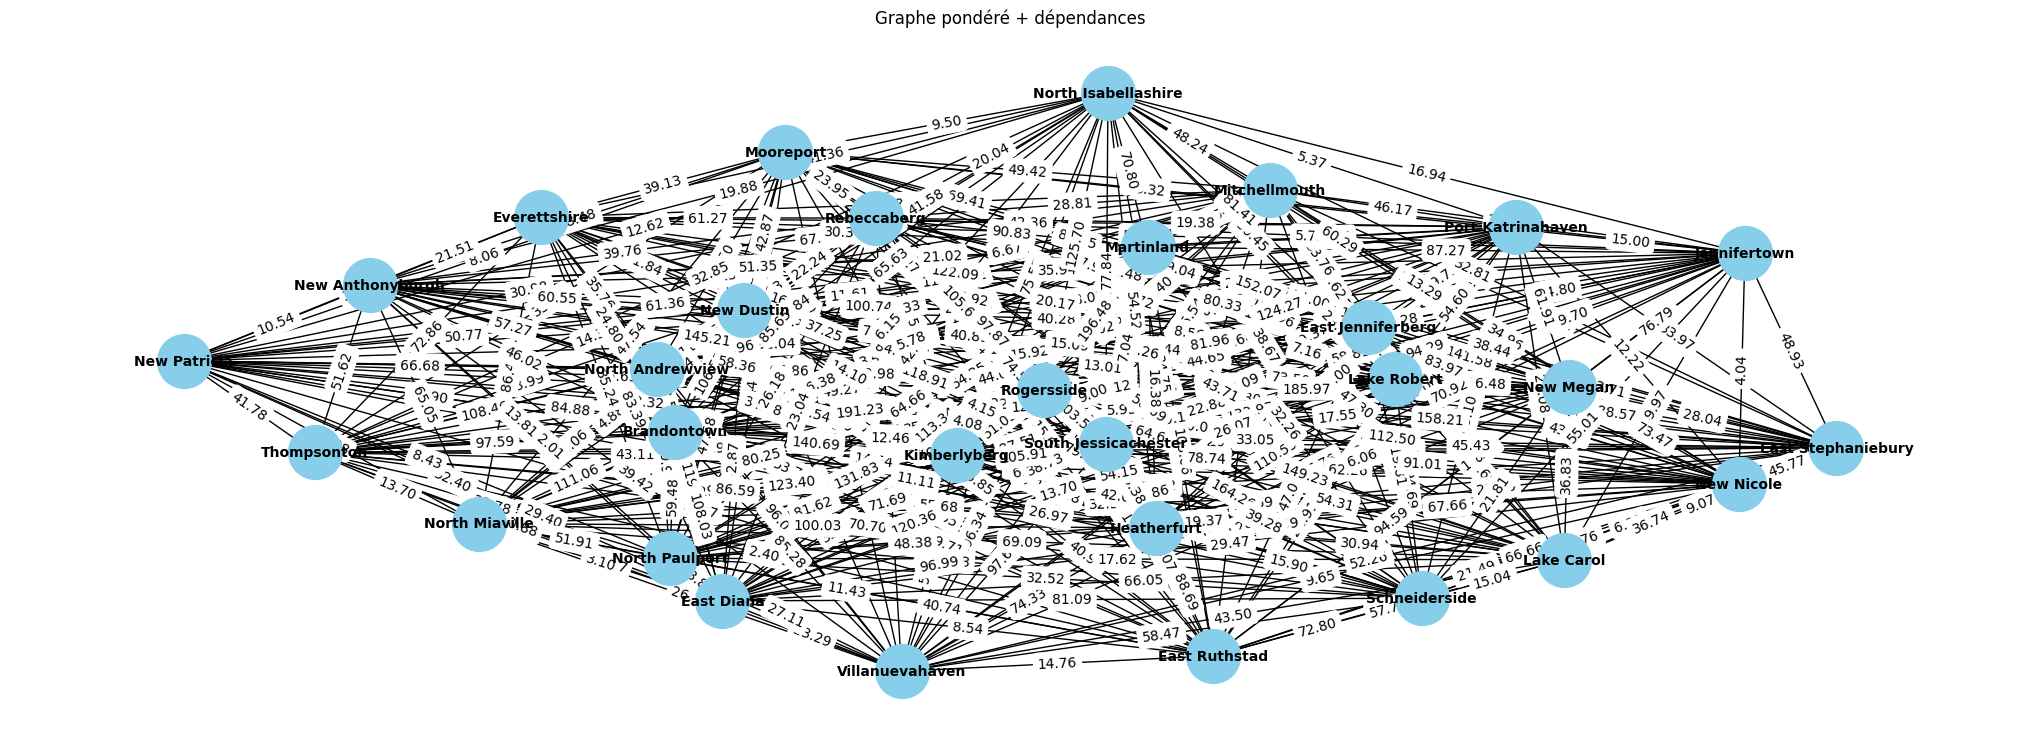

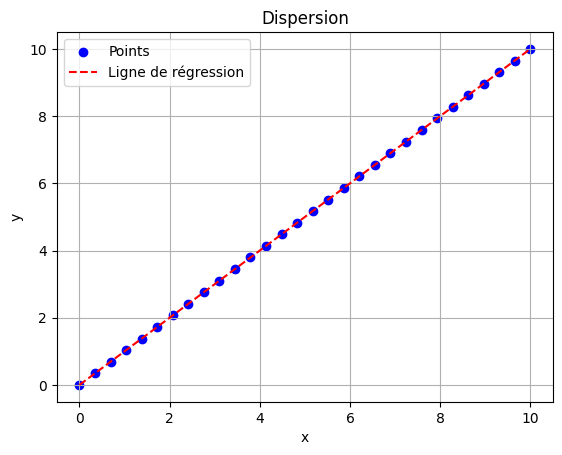

Le dictionnaire du graphe =  {'North Andrewview': {'Mooreport': 74.603, 'Villanuevahaven': 96.049, 'Kimberlyberg': 151.543, 'Mitchellmouth': 124.015, 'New Patricia': 66.683, 'Thompsonton': 108.462, 'New Dustin': 117.447, 'Lake Robert': 132.541, 'East Ruthstad': 110.649, 'Everettshire': 35.759, 'East Jenniferberg': 157.727, 'North Miaville': 122.06, 'Port Katrinahaven': 78.067, 'East Diana': 119.067, 'East Stephaniebury': 44.279, 'Jennifertown': 93.068, 'New Anthonyburgh': 57.268, 'Brandontown': 12.582, 'Lake Carol': 53.347, 'Schneiderside': 38.531, 'Heatherfurt': 23.17, 'Rogersside': 202.308, 'New Nicole': 90.013, 'South Jessicachester': 8.384, 'Martinland': 10.33, 'New Megan': 18.511, 'North Paulport': 70.957, 'North Isabellashire': 77.088, 'Rebeccaberg': 97.03}, 'Mooreport': {'North Andrewview': 74.603, 'Villanuevahaven': 21.448, 'Kimberlyberg': 76.941, 'Mitchellmouth': 49.416, 'New Patricia': 8.06, 'Thompsonton': 33.885, 'New Dustin': 42.87, 'Lake Robert': 57.961, 'East Ruthstad': 3

In [7]:
Instance1 = instances[2]
dependances1 = dependances_list[2]
x1 = x_list[0]
y1 = y_list[0]


G = nx.Graph()
PonderationDeps(Instance1, G)
pos = nx.spring_layout(G, seed=42)

# Affichage pondérations
plt.figure(figsize=(20, 7))
nx.draw(G, pos, with_labels=True,
        node_color='skyblue', node_size=1500,
        font_size=10, font_weight='bold')

# Étiquettes poids
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


G_dep = nx.DiGraph()
dep_labels = {}


plt.title("Graphe pondéré + dépendances")
plt.axis('off')
plt.show()

# Affichage points et ligne de régression 
a, b = 1, 0 
plt.scatter(x1, y1, color='blue', label='Points')
plt.plot(x1, a * x1 + b, 'r--', label='Ligne de régression')
plt.title(f"Dispersion")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

print("Le dictionnaire du graphe = ", Instance1)
print("Les dépandances du graphe = ", dependances1)

# II/ Modélisation

## 2.1 Implémentation

In [ ]:
def VRP(K, dico, dependances) :

    if K == 1 : 
        print(f"Le nombre de vehicules doit etre superieur a {K}")
        return

    cities = list(dico.keys())
    n = len(cities)
    city_index = {city: idx for idx, city in enumerate(cities)}  # Conversion du nom en index

    distance = {}
    for i in cities:
        for j in dico[i]:
            distance[(city_index[i], city_index[j])] = dico[i][j]

    model = LpProblem("VRP", LpMinimize)

    # Varible de décision 
    # x[i, j, k] = 1 si le véhicule k va de i à j
    x = LpVariable.dicts("x", ((i, j, k) for i in range(n) for j in range(n) if i != j for k in range(K)), cat='Binary')

    # MTZ
    u = LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1, cat='Integer')

    # Minimisation de la distance totale parcourue
    model += lpSum(distance[i, j] * x[i, j, k] for (i, j) in distance for k in range(K))

    # Contrainte 1 : Chaque ville est visitée exactement une fois
    for i in range(1, n): 
        model += lpSum(x[i, j, k] for j in range(n) if i != j for k in range(K)) == 1
        model += lpSum(x[j, i, k] for j in range(n) if i != j for k in range(K)) == 1

    # Contrainte 2 : Chaque ville quitte le dépôt et y revient
    for k in range(K):
        model += lpSum(x[0, j, k] for j in range(1, n)) == 1
        model += lpSum(x[i, 0, k] for i in range(1, n)) == 1 

    # Eviter les sous-tours (Contrainte MTZ)
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                for k in range(K):
                    model += u[i] - u[j] + 1 <= n*(1 - x[i, j, k])


    # Contrainte 3 : Dépendances entre villes ; ville 1 avant ville 2
    L = [(city_index[i], city_index[j]) for (i, j) in dependances]

    for (i, j) in L:
        model += lpSum(x[i, j, k] for k in range(K)) == 1

    for i in range(1, n):
        for k in range(K):
            model += lpSum(x[i, j, k] for j in range(n) if i != j) == lpSum(x[j, i, k] for j in range(n) if i != j)


    model.solve(PULP_CBC_CMD(msg=False))
            
    return value(model.objective) if (LpStatus[model.status] == "Optimal") else None

## 2.2 Résultats pour les 5 instances

In [ ]:
K = 2
for i in range(len(instances)):
    print(VRP(K, instances[i], dependances_list[i]))

58.51700000000001


# III/ Recherche Tabou

In [8]:
# Définir la distance totale du chemin
def valeur_contenu(routes, distances):
    total_cost = 0
    for route in routes:
        # on ignore les routes vides
        if len(route) < 2:
            continue
        for i in range(len(route) - 1):
            a, b = route[i], route[i + 1]
            if a == b:
                continue
            total_cost += distances.get(a, {}).get(b, 0)
    return total_cost


def random_solution(K, Depandance, villes, depot):
    autres_villes = [v for v in villes if v != depot]
    # Construction des liens père/fils à partir de Depandance
    pere_to_fils = dict(Depandance)
    fils_set = set(fils for pere, fils in Depandance)

    # Trouver les racines (ceux qui ne sont fils de personne)
    racines = [v for v in autres_villes if v not in fils_set]

    random.shuffle(racines)

    solution = []
    visited = set()

    for racine in racines:
        current = racine
        while current:
            if current not in visited:
                solution.append(current)
                visited.add(current)
            current = pere_to_fils.get(current)

    # Ajouter les villes restantes (qui n'ont pas de dépendances)
    for v in autres_villes:
        if v not in visited:
            solution.append(v)

    routes = [[] for _ in range(K)]
    routes[0] = [depot] + solution + [depot]
    
    return tuple(routes)

# On effectue les voisins d'une route, cad on change une ville au sein d'un même véhicule ou on la déplace dans un autre véhicule
@lru_cache(maxsize=None)
def voisinage(routes, Depandance, depot):
    voisins = []
    routes = [list(route) for route in routes]  

    villes = [ville for route in routes for ville in route if ville != depot]

    for _ in range(30):
        new_routes = [list(route) for route in routes]

        ville = random.choice(villes)

        # Verification dépendance
        deplacement_possible = True
        for pere, fils in Depandance:
            if ville == pere or ville == fils:
                deplacement_possible = False
                break  # Si la ville est dans une dépendance, on ne la déplace pas

        if not deplacement_possible:
            continue  # Si la ville est dans une dépendance, on passe à une autre ville

        # On cherhce ou se trouve la ville
        for idx_route_src, route in enumerate(new_routes):
            if ville in route:
                idx_ville = route.index(ville)
                break

        # Changement de place au sein du même véhicule 
        if random.random() < 0.1:  
            route = new_routes[idx_route_src]

            if len(route) > 3:  # Il faut au moins 1 ville (dépôt + ville + dépôt)
                # Retirer et replacer à une autre position
                ville = route.pop(idx_ville)
                insert_pos = random.randint(1, len(route) - 1)  # entre les dépôts
                route.insert(insert_pos, ville)
        else:  
            new_routes[idx_route_src].pop(idx_ville)

            # On choisit un autre véhicule
            possible_destinations = [i for i in range(len(routes)) if i != idx_route_src]
            idx_route_dst = random.choice(possible_destinations)
            route_dst = new_routes[idx_route_dst]

            if not route_dst:  # Si le véhicule est vide
                route_dst.extend([depot, ville, depot])
            else:
                insert_pos = random.randint(1, len(route_dst) - 1)
                route_dst.insert(insert_pos, ville)

        voisins.append(tuple(tuple(r) for r in new_routes))
    return voisins

def recherche_tabou(solution_initiale, taille_tabou, iter_max, Depandance, distances, depot):
    courant = [list(item) for item in solution_initiale]
    meilleur = courant
    tabou = deque(maxlen=taille_tabou)
    voisins = [list(item) for item in solution_initiale]
    courantes = [valeur_contenu(courant, distances)]
    meilleures_courantes = [valeur_contenu(meilleur, distances)]
    for _ in range(iter_max):
        voisins = voisinage(tuple(tuple(r) for r in courant),tuple(Depandance), depot)
        admissibles = [v for v in voisins if v not in tabou]

        if not admissibles:
            break

        courant = min(admissibles, key=lambda sol: valeur_contenu(sol, distances))
        tabou.append(courant)

        # Mise à jour de la meilleure solution rencontrée
        if valeur_contenu(courant, distances) < valeur_contenu(meilleur, distances):
            meilleur = courant

        courantes.append(valeur_contenu(courant, distances))
        meilleures_courantes.append(valeur_contenu(meilleur, distances))

    return meilleur, courantes, meilleures_courantes

Faisons-le pour les 5 instances générées et stockons les solutions afin de les comparer par la suite avec notre borne inférieure.


--- Résultats pour l'Instance 1 ---
Solution initiale : 139.470
Solution d'amélioration : 84.853
Taille de la liste tabou : 500


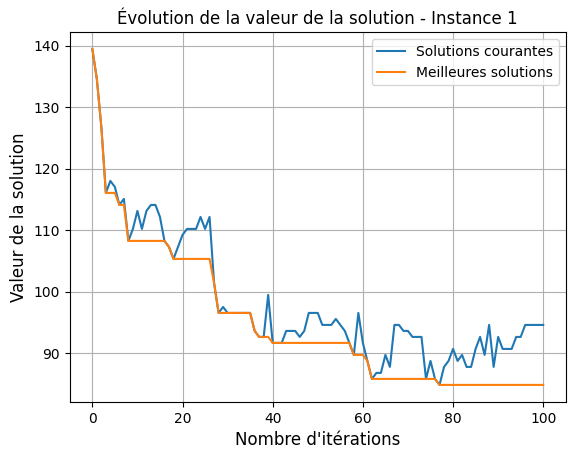

Solution améliorée : (('Lauraland', 'East Sharon', 'New Brandifort', 'Melindastad', 'Stevenschester', 'South Rachael', 'Lake Brittanyfurt', 'South Michaeltown', 'New Anthony', 'Smithmouth', 'Grantville', 'Lake Kelly', 'Mitchellfort', 'Port Kimberly', 'West Jamesfort', 'Tiffanyberg', 'Armstrongport', 'Robertfort', 'West Juliemouth', 'Lake Taramouth', 'East Toni', 'Arnoldmouth', 'Tonyaview', 'Lake Lawrence', 'Houstonberg', 'Butlerborough', 'Lake Glen', 'Jasonburgh', 'Lake Jessicamouth', 'New Andrewview', 'Lauraland'), ('Lauraland', 'Lauraland')) 84.853

--- Résultats pour l'Instance 2 ---
Solution initiale : 370.561
Solution d'amélioration : 194.989
Taille de la liste tabou : 500


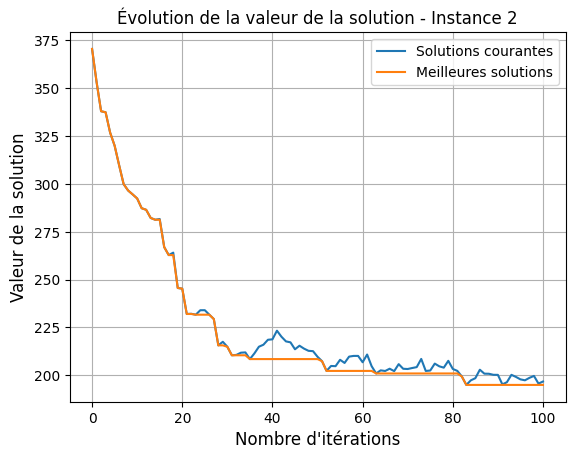

Solution améliorée : (('South Stevenside', 'Traciemouth', 'New Arthurtown', 'Silvaview', 'New Markstad', 'Leahshire', 'Williamhaven', 'Lake Brandon', 'South Patricia', 'Shelbychester', 'New Aaronland', 'West Saratown', 'Jennachester', 'Stonefort', 'Brendanfort', 'Olsonshire', 'Michaeltown', 'Catherinechester', 'West Kristen', 'Sharonshire', 'South Toddport', 'East Christopher', 'Manningview', 'Lake Vincent', 'Port Thomas', 'Murphybury', 'Pageton', 'Sandratown', 'East Josephside', 'South Stevenside'), ('South Stevenside', 'Jeanburgh', 'South Stevenside')) 194.989

--- Résultats pour l'Instance 3 ---
Solution initiale : 1716.479
Solution d'amélioration : 770.897
Taille de la liste tabou : 500


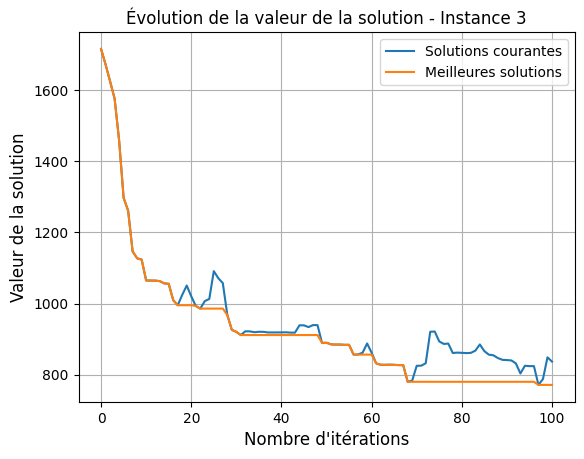

Solution améliorée : (('North Andrewview', 'South Jessicachester', 'Everettshire', 'New Anthonyburgh', 'Jennifertown', 'North Miaville', 'Mitchellmouth', 'Lake Robert', 'East Ruthstad', 'New Nicole', 'Rebeccaberg', 'New Dustin', 'Mooreport', 'East Stephaniebury', 'New Megan', 'Schneiderside', 'Lake Carol', 'North Paulport', 'Port Katrinahaven', 'Villanuevahaven', 'Thompsonton', 'Kimberlyberg', 'Rogersside', 'East Jenniferberg', 'East Diana', 'North Isabellashire', 'New Patricia', 'North Andrewview'), ('North Andrewview', 'Brandontown', 'Martinland', 'Heatherfurt', 'North Andrewview')) 770.897

--- Résultats pour l'Instance 4 ---
Solution initiale : 2829.221
Solution d'amélioration : 1304.741
Taille de la liste tabou : 500


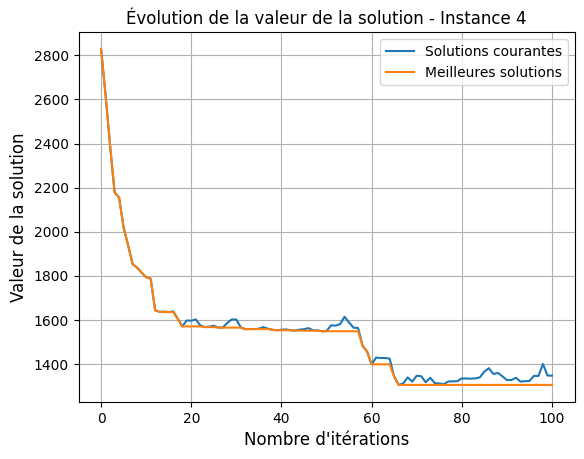

Solution améliorée : (('Port Tonymouth', 'Richardsonborough', 'Fowlerfurt', 'South Jonathanfort', 'Whiteton', 'South Nancyburgh', 'Greenmouth', 'Castroview', 'West David', 'Scottborough', 'Ramireztown', 'North Laura', 'Port Mark', 'Gardnerborough', 'Lake George', 'Jamestown', 'Jacksonport', 'Christineton', 'Mckenzieburgh', 'Barreraside', 'North Danieltown', 'Matthewtown', 'Leslieshire', 'Lake Rachael', 'Christineview', 'Ivanside', 'Port Tonymouth'), ('Port Tonymouth', 'Smithburgh', 'Lesliebury', 'Hilltown', 'North Angelaberg', 'Port Tonymouth')) 1304.741

--- Résultats pour l'Instance 5 ---
Solution initiale : 4034.626
Solution d'amélioration : 2336.904
Taille de la liste tabou : 500


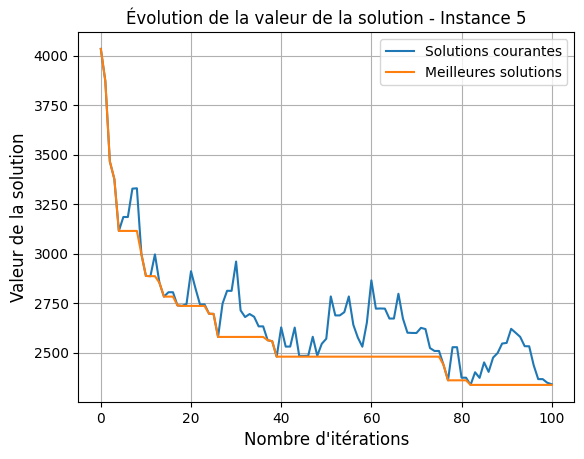

Solution améliorée : (('Alexanderton', 'Theresafurt', 'Paulburgh', 'North Marissa', 'Aarontown', 'South Curtis', 'North Pamela', 'Adamschester', 'Andrewbury', 'Antonioton', 'East Chelsea', 'East Natalie', 'Donnafurt', 'Mooretown', 'Port Joshuamouth', 'Michelleport', 'Riceland', 'East Nancy', 'North Amy', 'Vanessaborough', 'New Debraton', 'South Cassandrachester', 'New Carolineland', 'North Amanda', 'East Cindyfort', 'North Nicole', 'Port Katherine', 'Elliottfort', 'West Elizabeth', 'Gabrielstad', 'Alexanderton'), ('Alexanderton', 'Alexanderton')) 2336.904


In [15]:
iter_max = 100
taille_tabou = 500
K = 2
final = []

for i in range(len(instances)):
    print(f"\n--- Résultats pour l'Instance {i + 1} ---")
    
    distances = instances[i]
    Depandance = dependances_list[i]
    villes = list(distances.keys())
    depot = villes[0]

    initial_solution = random_solution(K, Depandance, villes, depot)
    print(f"Solution initiale : {valeur_contenu(initial_solution, distances):.3f}")
    
    solution_finale, courants, meilleurs_courants = recherche_tabou(
        initial_solution, taille_tabou, iter_max, Depandance, distances, depot
    )

    print(f"Solution d'amélioration : {valeur_contenu(solution_finale, distances):.3f}")
    final.append(valeur_contenu(solution_finale, distances))
    print("Taille de la liste tabou :", taille_tabou)
    plt.plot(range(len(courants)), courants, label="Solutions courantes")
    plt.plot(range(len(courants)), meilleurs_courants, label="Meilleures solutions")
    plt.xlabel("Nombre d'itérations", fontsize=12)
    plt.ylabel("Valeur de la solution", fontsize=12)
    plt.title(f"Évolution de la valeur de la solution - Instance {i + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()


    print(f"Solution améliorée : {solution_finale} {valeur_contenu(solution_finale, distances):.3f}")

# IV/ Qualité de la solution

### 4.1 Calcul de la borne inférieure avec un solveur PLNE

Notre solveur PLNE renvoie des valeurs optimales selon lui. Or, nous devons **relaxer certaines variables et contraintes** pour pouvoir obtenir une **borne inférieure**.

Cette borne va tendre vers 0 grâce aux relaxations suivantes :

- Les **variables `x` et `u`** peuvent prendre des **valeurs continues** et non plus discrètes.
- Les **contraintes de dépendance**, au lieu d'être formulées avec `== 1`, sont remplacées par `>= 0.8` pour permettre une certaine flexibilité.

Ainsi, cette borne inférieure nous permettra de **comparer objectivement notre solution** avec celle obtenue via notre algorithme **Tabu Search**.


In [16]:
def borne_inf(K, dico, dependances) :

    if K == 1 : 
        print(f"Le nombre de vehicules doit etre superieur a {K}")
        return

    cities = list(dico.keys())
    n = len(cities)
    city_index = {city: idx for idx, city in enumerate(cities)}  

    distance = {}
    for i in cities:
        for j in dico[i]:
            distance[(city_index[i], city_index[j])] = dico[i][j]

    model = LpProblem("VRP", LpMinimize)

    x = LpVariable.dicts("x", ((i, j, k) for i in range(n) for j in range(n) if i != j for k in range(K)),0,1) # On relaxe a entre 0 et 1

    u = LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1) # On relaxe entre 0 et n-1

    model += lpSum(distance[i, j] * x[i, j, k] for (i, j) in distance if i != j for k in range(K))

    for i in range(1, n):  
        model += lpSum(x[i, j, k] for j in range(n-1) if i != j for k in range(K)) >= 0.5
        model += lpSum(x[j, i, k] for j in range(n-1) if i != j for k in range(K)) >= 0.5

    for k in range(K):
        model += lpSum(x[0, j, k] for j in range(1, n)) == 1
        model += lpSum(x[i, 0, k] for i in range(1, n)) == 1 

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                for k in range(K):
                    model += u[i] - u[j] + 1 <= n*(1 - x[i, j, k])

    L = [(city_index[i], city_index[j]) for (i, j) in dependances]

    for (i, j) in L:
        model += lpSum(x[i, j, k] for k in range(K)) == 1

    for i in range(1, n):
        for k in range(K):
            model += lpSum(x[i, j, k] for j in range(n) if i != j) == lpSum(x[j, i, k] for j in range(n) if i != j)

    # Résolution 
    model.solve(PULP_CBC_CMD(msg=False))

    return value(model.objective) if (LpStatus[model.status] == "Optimal") else None

In [17]:
K = 2 
resultats =[]
for i in range(len(instances)):
    resultats.append(borne_inf(K, instances[i], dependances_list[i]))
    print(f"Borne inférieure pour l'instance {i+1} : {resultats[i]:.2f}")

Borne inférieure pour l'instance 1 : 55.10
Borne inférieure pour l'instance 2 : 102.30
Borne inférieure pour l'instance 3 : 539.85
Borne inférieure pour l'instance 4 : 715.93
Borne inférieure pour l'instance 5 : 1230.97


Nous allons maintenant comparer les solutions obtenues par la recherche tabou avec les bornes inférieures, afin d’évaluer leur qualité et vérifier si elles s’en rapprochent.

In [20]:
for i in range(len(instances)):
    print(f"La borne inférieur : {resultats[i]:.2f}")
    print(f"valeur de la solution Tabou pour l'instance {i+1} = {final[i]:.2f}")

La borne inférieur : 55.10
valeur de la solution Tabou pour l'instance 1 = 84.85
La borne inférieur : 102.30
valeur de la solution Tabou pour l'instance 2 = 194.99
La borne inférieur : 539.85
valeur de la solution Tabou pour l'instance 3 = 770.90
La borne inférieur : 715.93
valeur de la solution Tabou pour l'instance 4 = 1304.74
La borne inférieur : 1230.97
valeur de la solution Tabou pour l'instance 5 = 2336.90


On peut constater que plus la dispersion et le nombre de villes augmentent, plus notre solution s’éloigne de la borne inférieure. Nous allons essayer de nous en rapprocher au maximum en utilisant la méthode du **multi-start**.

In [24]:
import time

iter_max = 100
taille_tabou = 500
K = 2

for i in range(len(instances)):
    for _ in range(100):
        val_min = float('+inf')
        sol_min = None
        distances = instances[i]
        Depandance = dependances_list[i]
        villes = list(distances.keys())
        depot = villes[0]
        initial_solution = random_solution(K, Depandance, villes, depot)
        solution_courante, courants, meilleurs_courants = recherche_tabou(initial_solution, taille_tabou, iter_max, Depandance, distances, depot)
    
        val_courante = valeur_contenu(solution_courante, distances)
        if (val_courante < val_min):
            val_min = val_courante
            sol_min = solution_courante
    print(f" Amélioration de l'intance {i +1} : {valeur_contenu(sol_min, distances):.3f}")

 Amélioration de l'intance 1 : 72.174
 Amélioration de l'intance 2 : 207.841
 Amélioration de l'intance 3 : 1057.598
 Amélioration de l'intance 4 : 1208.587
 Amélioration de l'intance 5 : 2284.138


On peut constater que plus on augmente les itérations, plus les solutions obtenues seront nettement meilleures et se rapprocheront davantage de la borne inférieure. Il est important de noter qu’il est impossible pour une solution d’atteindre exactement cette borne, car celle-ci est issue d’une relaxation : elle représente donc une solution idéale que l’on souhaiterait obtenir pour nos instances. L’objectif est donc de s’en approcher le plus possible, ce qui est favorisé par l’augmentation du nombre d’itérations. En effet, cela permet à l’algorithme de trouver de meilleures solutions parmi toutes celles déjà explorées.

# V/ Plan d'expérience

Regardons maintenant la performance de notre algorithme en comparant les valeurs obtenues pour chaque instance à la borne inférieure qui leur est associée.  L'objectif est de s'en rapprocher le plus possible afin d'obtenir une solution dite "optimale". Cependant, il est important de noter que cette borne ne pourra jamais être atteinte, car elle provient d'une relaxation du problème.

IntProgress(value=0, layout=Layout(width='100%'))

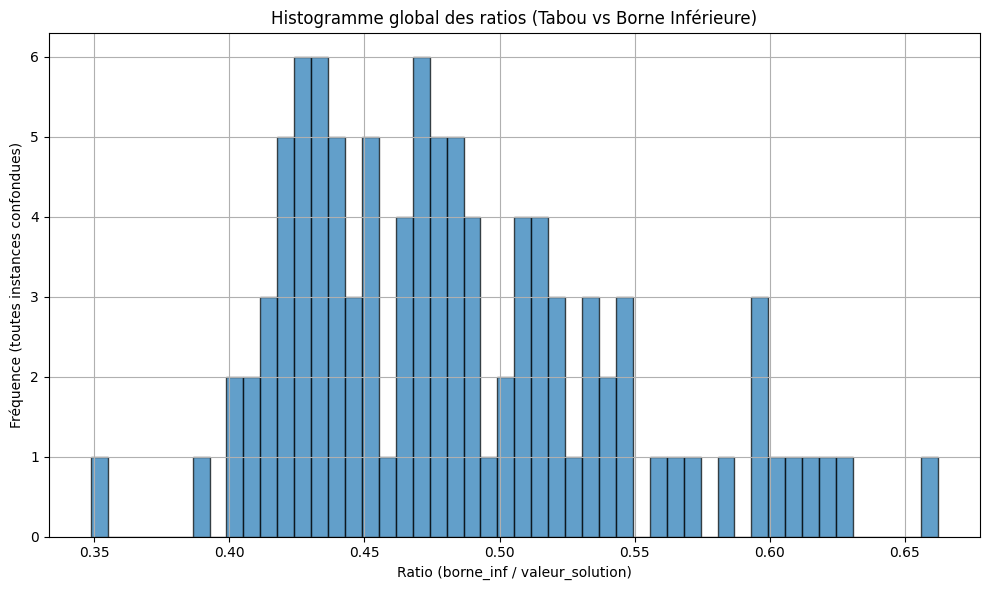

Moyenne : 0.48364291419279676
Médiane : 0.47499736138277804
Écart-type : 0.06065460754665464
Min : 0.3487332073312922
Max : 0.6622262501890305
Temps total : 8.078125 secondes


In [27]:
tous_les_ratios = []

start = time.process_time()

taille_tabou = 500
iter_max = 20
K = 2
nb_tests = 20

bar = IntProgress(min=0, max=len(instances)*nb_tests, layout={"width" : "100%"})
display(bar)

for i in range(len(instances)) :
    distances = instances[i]
    Depandance = dependances_list[i]
    villes = list(distances.keys())

    for _ in range(nb_tests):
        depot = villes[0]
        initial_solution = random_solution(K, Depandance, villes, depot)
        solution_courante, courants, meilleurs_courants = recherche_tabou(initial_solution, taille_tabou, iter_max, Depandance, distances, depot)
        valeur_solution = valeur_contenu(solution_courante, distances)
        borne = borne_inf(K, distances, Depandance)

        ratio = borne / valeur_solution
        tous_les_ratios.append(ratio)
        bar.value += 1

bar.close()
stop = time.process_time()

# Affichage de l'histogramme global
plt.figure(figsize=(10, 6))
plt.hist(tous_les_ratios, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Ratio (borne_inf / valeur_solution)")
plt.ylabel("Fréquence (toutes instances confondues)")
plt.title("Histogramme global des ratios (Tabou vs Borne Inférieure)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistiques de base
bornes_array = np.array(tous_les_ratios)
print("Moyenne :", np.mean(bornes_array))
print("Médiane :", np.median(bornes_array))
print("Écart-type :", np.std(bornes_array))
print("Min :", np.min(bornes_array))
print("Max :", np.max(bornes_array))

print("Temps total :", stop - start, "secondes")


On peut voir que, sur l'ensemble de nos instances, 6 d’entre elles ont trouvé une solution atteignant environ 49 % de la borne inférieure, ce qui n’est pas si mal !  
Ce qui nous intéresse ici, ce sont les statistiques principales, notamment le minimum et le maximum. On observe que la valeur minimale atteint 35 % de la borne inférieure, tandis que la valeur maximale s’en rapproche à 64 %. Ainsi, une instance a réussi à se rapprocher de la borne à hauteur de 64 %, ce qui représente notre meilleur résultat.
